# Credit Card Default Prediction - Complete Analysis
## Machine Learning Model Comparison with SHAP Explainability

**Author:** [Your Name]  
**Date:** October 2025  

This notebook implements and compares 5 machine learning models:
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. XGBoost
5. Neural Network

**Goal:** Analyze the interpretability-performance tradeoff using SHAP values.

---
## Step 2: Import Libraries

Now let's import all the necessary libraries.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# SHAP for explainability
import shap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('default')

print("✓ All libraries imported successfully!")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


✓ All libraries imported successfully!


---
## Step 2: Load the Data

Load your training and testing datasets. Make sure `train.csv` and `test.csv` are in the same folder as this notebook.

In [2]:
# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")
print(f"\n{'='*50}")
print("First few rows of training data:")
print(train_df.head())

Training data shape: (255347, 18)
Testing data shape: (109435, 17)

First few rows of training data:
       LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
0  I38PQUQS96   56   85994       50587          520              80   
1  HPSK72WA7R   69   50432      124440          458              15   
2  C1OZ6DPJ8Y   46   84208      129188          451              26   
3  V2KKSFM3UN   32   31713       44799          743               0   
4  EY08JDHTZP   60   20437        9139          633               8   

   NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
0               4         15.23        36      0.44   Bachelor's   
1               1          4.81        60      0.68     Master's   
2               3         21.17        24      0.31     Master's   
3               3          7.07        24      0.23  High School   
4               4          6.51        48      0.73   Bachelor's   

  EmploymentType MaritalStatus HasMortgage HasDependents LoanPu

---
## Step 3: Exploratory Data Analysis (EDA)

Let's examine the data to understand its structure and characteristics.

In [3]:
# Basic information
print("Dataset Info:")
print(train_df.info())

print("\n" + "="*50)
print("Summary Statistics:")
print(train_df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 

In [4]:
# Check for missing values
print("Missing Values:")
missing = train_df.isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values found!")
else:
    print(missing[missing > 0])

Missing Values:
✓ No missing values found!


Target Variable Distribution:
Default
0    225694
1     29653
Name: count, dtype: int64

Default Rate: 11.61%


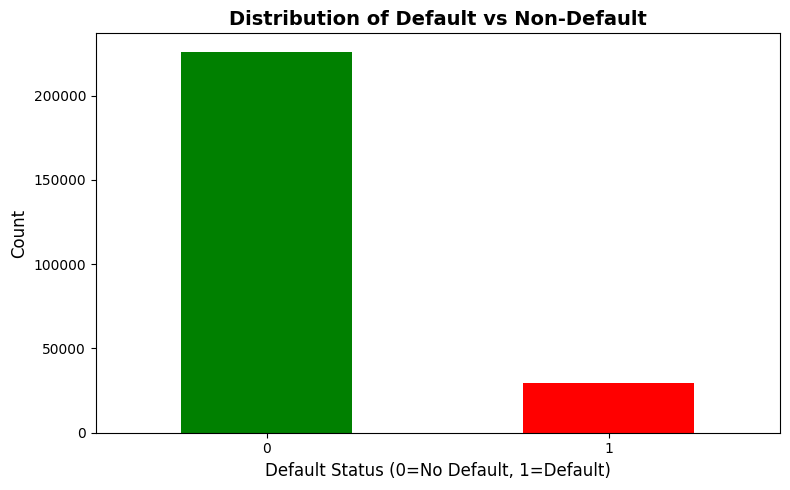

In [5]:
# Target variable distribution
print("Target Variable Distribution:")
print(train_df['Default'].value_counts())
print(f"\nDefault Rate: {train_df['Default'].mean():.2%}")

# Visualize
plt.figure(figsize=(8, 5))
train_df['Default'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Default vs Non-Default', fontsize=14, fontweight='bold')
plt.xlabel('Default Status (0=No Default, 1=Default)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

---
## Step 4: Data Preprocessing

Prepare the data for modeling:
- Separate features and target
- Encode categorical variables
- Scale numerical features

In [6]:
from sklearn.model_selection import train_test_split

# Use ALL of train_df and split it ourselves
print("="*70)
print("DATA SPLITTING")
print("="*70)

# Separate features and target from training data
X = train_df.drop(['Default', 'LoanID'], axis=1)
y = train_df['Default']

print(f"\nOriginal data shape: {train_df.shape}")
print(f"Default rate: {y.mean():.2%}")

# Split into train and test (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Keeps same default rate in both sets
)

print(f"\nAfter split:")
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training samples: {len(y_train)}")
print(f"Testing samples: {len(y_test)}")
print(f"Training default rate: {y_train.mean():.2%}")
print(f"Testing default rate: {y_test.mean():.2%}")
print("="*70)


DATA SPLITTING

Original data shape: (255347, 18)
Default rate: 11.61%

After split:
Training features shape: (204277, 16)
Testing features shape: (51070, 16)
Training samples: 204277
Testing samples: 51070
Training default rate: 11.61%
Testing default rate: 11.61%


In [7]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")
print(f"\nNumerical features ({len(numerical_cols)}): {numerical_cols}")

Categorical features (7): ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']

Numerical features (9): ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']


In [8]:
# One-hot encode categorical variables
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Ensure train and test have same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

print(f"After encoding, feature count: {X_train_encoded.shape[1]}")
print("\nSample of encoded features:")
print(X_train_encoded.head())

After encoding, feature count: 24

Sample of encoded features:
        Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
15826    45   37039      247916          624              19               2   
147371   48  133963       66275          494             119               3   
178180   47  100204        6967          718             108               3   
126915   42   36078       25966          344               2               3   
163930   20   99464      248557          318              74               3   

        InterestRate  LoanTerm  DTIRatio  Education_High School  \
15826           4.62        60      0.85                   True   
147371         14.72        48      0.49                  False   
178180          5.51        24      0.76                   True   
126915         18.29        36      0.76                  False   
163930         19.45        60      0.45                  False   

        Education_Master's  Education_PhD  Employment

In [9]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train_encoded[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test_encoded[numerical_cols])

print("✓ Feature scaling complete!")
print(f"\nFinal feature shape: {X_train_scaled.shape}")

✓ Feature scaling complete!

Final feature shape: (204277, 24)


---
## Step 5: Model Training

Now we'll train all 5 models. Each model will be trained in a separate cell so you can see progress.

### 5.1 Logistic Regression (Baseline)

In [10]:
print("Training Logistic Regression...")

lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_roc_auc = roc_auc_score(y_test, lr_pred_proba)

print("\n✓ Logistic Regression Results:")
print(f"  Accuracy:  {lr_accuracy:.4f}")
print(f"  Precision: {lr_precision:.4f}")
print(f"  Recall:    {lr_recall:.4f}")
print(f"  F1-Score:  {lr_f1:.4f}")
print(f"  ROC-AUC:   {lr_roc_auc:.4f}")

Training Logistic Regression...

✓ Logistic Regression Results:
  Accuracy:  0.8853
  Precision: 0.6084
  Recall:    0.0341
  F1-Score:  0.0645
  ROC-AUC:   0.7531


### 5.2 Decision Tree

In [11]:
print("Training Decision Tree with hyperparameter tuning...")
print("(This may take a few minutes)\n")

# Hyperparameter grid
dt_param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_base = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_grid = GridSearchCV(dt_base, dt_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
dt_grid.fit(X_train_scaled, y_train)

dt_model = dt_grid.best_estimator_
dt_pred = dt_model.predict(X_test_scaled)
dt_pred_proba = dt_model.predict_proba(X_test_scaled)[:, 1]

print(f"\nBest parameters: {dt_grid.best_params_}")

# Evaluate
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)
dt_roc_auc = roc_auc_score(y_test, dt_pred_proba)

print("\n✓ Decision Tree Results:")
print(f"  Accuracy:  {dt_accuracy:.4f}")
print(f"  Precision: {dt_precision:.4f}")
print(f"  Recall:    {dt_recall:.4f}")
print(f"  F1-Score:  {dt_f1:.4f}")
print(f"  ROC-AUC:   {dt_roc_auc:.4f}")

Training Decision Tree with hyperparameter tuning...
(This may take a few minutes)

Fitting 5 folds for each of 45 candidates, totalling 225 fits

Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

✓ Decision Tree Results:
  Accuracy:  0.8849
  Precision: 0.6262
  Recall:    0.0218
  F1-Score:  0.0420
  ROC-AUC:   0.7159


### 5.3 Random Forest

In [12]:
print("Training Random Forest with hyperparameter tuning...")
print("(This may take 10-15 minutes)\n")

# Hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_base = RandomForestClassifier(random_state=RANDOM_STATE)
rf_grid = GridSearchCV(rf_base, rf_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_scaled, y_train)

rf_model = rf_grid.best_estimator_
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

print(f"\nBest parameters: {rf_grid.best_params_}")

# Evaluate
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)

print("\n✓ Random Forest Results:")
print(f"  Accuracy:  {rf_accuracy:.4f}")
print(f"  Precision: {rf_precision:.4f}")
print(f"  Recall:    {rf_recall:.4f}")
print(f"  F1-Score:  {rf_f1:.4f}")
print(f"  ROC-AUC:   {rf_roc_auc:.4f}")

Training Random Forest with hyperparameter tuning...
(This may take 10-15 minutes)

Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

✓ Random Forest Results:
  Accuracy:  0.8845
  Precision: 0.8261
  Recall:    0.0064
  F1-Score:  0.0127
  ROC-AUC:   0.7528


### 5.4 XGBoost

In [13]:
print("Training XGBoost with hyperparameter tuning...")

# Check if GPU is available for XGBoost
try:
    import tensorflow as tf
    gpu_available = len(tf.config.list_physical_devices('GPU')) > 0
except:
    gpu_available = False

if gpu_available:
    print("✓ Using GPU acceleration for XGBoost!")
    print("(This will take ~5-8 minutes with GPU)\n")
    tree_method = 'gpu_hist'
    predictor = 'gpu_predictor'
else:
    print("Using CPU (no GPU detected)")
    print("(This may take 10-15 minutes)\n")
    tree_method = 'hist'
    predictor = 'cpu_predictor'

# Hyperparameter grid
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_base = xgb.XGBClassifier(
    random_state=RANDOM_STATE, 
    use_label_encoder=False, 
    eval_metric='logloss',
    tree_method=tree_method,
    predictor=predictor
)
xgb_grid = GridSearchCV(xgb_base, xgb_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_scaled, y_train)

xgb_model = xgb_grid.best_estimator_
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

print(f"\nBest parameters: {xgb_grid.best_params_}")

# Evaluate
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)

print("\n✓ XGBoost Results:")
print(f"  Accuracy:  {xgb_accuracy:.4f}")
print(f"  Precision: {xgb_precision:.4f}")
print(f"  Recall:    {xgb_recall:.4f}")
print(f"  F1-Score:  {xgb_f1:.4f}")
print(f"  ROC-AUC:   {xgb_roc_auc:.4f}")

Training XGBoost with hyperparameter tuning...
Using CPU (no GPU detected)
(This may take 10-15 minutes)

Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

✓ XGBoost Results:
  Accuracy:  0.8867
  Precision: 0.6188
  Recall:    0.0632
  F1-Score:  0.1147
  ROC-AUC:   0.7593


### 5.5 Neural Network

In [14]:
print("Training Neural Network...")
print("(This may take 5-10 minutes)\n")

# Convert data to proper numpy arrays with float32 dtype
X_train_nn = X_train_scaled.values.astype('float32') if hasattr(X_train_scaled, 'values') else X_train_scaled.astype('float32')
y_train_nn = y_train.values.astype('float32') if hasattr(y_train, 'values') else y_train.astype('float32')
X_test_nn = X_test_scaled.values.astype('float32') if hasattr(X_test_scaled, 'values') else X_test_scaled.astype('float32')

# Build model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
history = nn_model.fit(
    X_train_nn, y_train_nn,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predictions
nn_pred_proba = nn_model.predict(X_test_nn).flatten()
nn_pred = (nn_pred_proba > 0.5).astype(int)

# Evaluate
nn_accuracy = accuracy_score(y_test, nn_pred)
nn_precision = precision_score(y_test, nn_pred)
nn_recall = recall_score(y_test, nn_pred)
nn_f1 = f1_score(y_test, nn_pred)
nn_roc_auc = roc_auc_score(y_test, nn_pred_proba)

print("\n✓ Neural Network Results:")
print(f"  Accuracy:  {nn_accuracy:.4f}")
print(f"  Precision: {nn_precision:.4f}")
print(f"  Recall:    {nn_recall:.4f}")
print(f"  F1-Score:  {nn_f1:.4f}")
print(f"  ROC-AUC:   {nn_roc_auc:.4f}")

Training Neural Network...
(This may take 5-10 minutes)

Epoch 1/100
5107/5107 [==============================] - 8s 1ms/step - loss: 0.3358 - accuracy: 0.8818 - val_loss: 0.3153 - val_accuracy: 0.8869
Epoch 2/100
5107/5107 [==============================] - 7s 1ms/step - loss: 0.3229 - accuracy: 0.8839 - val_loss: 0.3138 - val_accuracy: 0.8860
Epoch 3/100
5107/5107 [==============================] - 6s 1ms/step - loss: 0.3203 - accuracy: 0.8840 - val_loss: 0.3127 - val_accuracy: 0.8861
Epoch 4/100
5107/5107 [==============================] - 6s 1ms/step - loss: 0.3193 - accuracy: 0.8838 - val_loss: 0.3116 - val_accuracy: 0.8868
Epoch 5/100
5107/5107 [==============================] - 7s 1ms/step - loss: 0.3187 - accuracy: 0.8839 - val_loss: 0.3120 - val_accuracy: 0.8863
Epoch 6/100
5107/5107 [==============================] - 7s 1ms/step - loss: 0.3181 - accuracy: 0.8843 - val_loss: 0.3121 - val_accuracy: 0.8861
Epoch 7/100
5107/5107 [==============================] - 7s 1ms/step - lo

---
## Step 6: Model Comparison

Let's compare all models side by side.

In [15]:
# Create results dataframe
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Neural Network'],
    'Accuracy': [lr_accuracy, dt_accuracy, rf_accuracy, xgb_accuracy, nn_accuracy],
    'Precision': [lr_precision, dt_precision, rf_precision, xgb_precision, nn_precision],
    'Recall': [lr_recall, dt_recall, rf_recall, xgb_recall, nn_recall],
    'F1-Score': [lr_f1, dt_f1, rf_f1, xgb_f1, nn_f1],
    'ROC-AUC': [lr_roc_auc, dt_roc_auc, rf_roc_auc, xgb_roc_auc, nn_roc_auc]
})

# Sort by ROC-AUC
results_df = results_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

print("\n" + "="*70)
print("MODEL COMPARISON - SORTED BY ROC-AUC")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# Save to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("\n✓ Results saved to 'model_comparison_results.csv'")


MODEL COMPARISON - SORTED BY ROC-AUC
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
            XGBoost  0.886685   0.618812 0.063227  0.114732 0.759254
     Neural Network  0.885432   0.662602 0.027483  0.052776 0.757714
Logistic Regression  0.885275   0.608434 0.034058  0.064506 0.753106
      Random Forest  0.884453   0.826087 0.006407  0.012715 0.752774
      Decision Tree  0.884883   0.626214 0.021750  0.042040 0.715950

✓ Results saved to 'model_comparison_results.csv'


---
## Step 7: Visualizations

Create visualizations for your paper.

### 7.1 ROC Curves

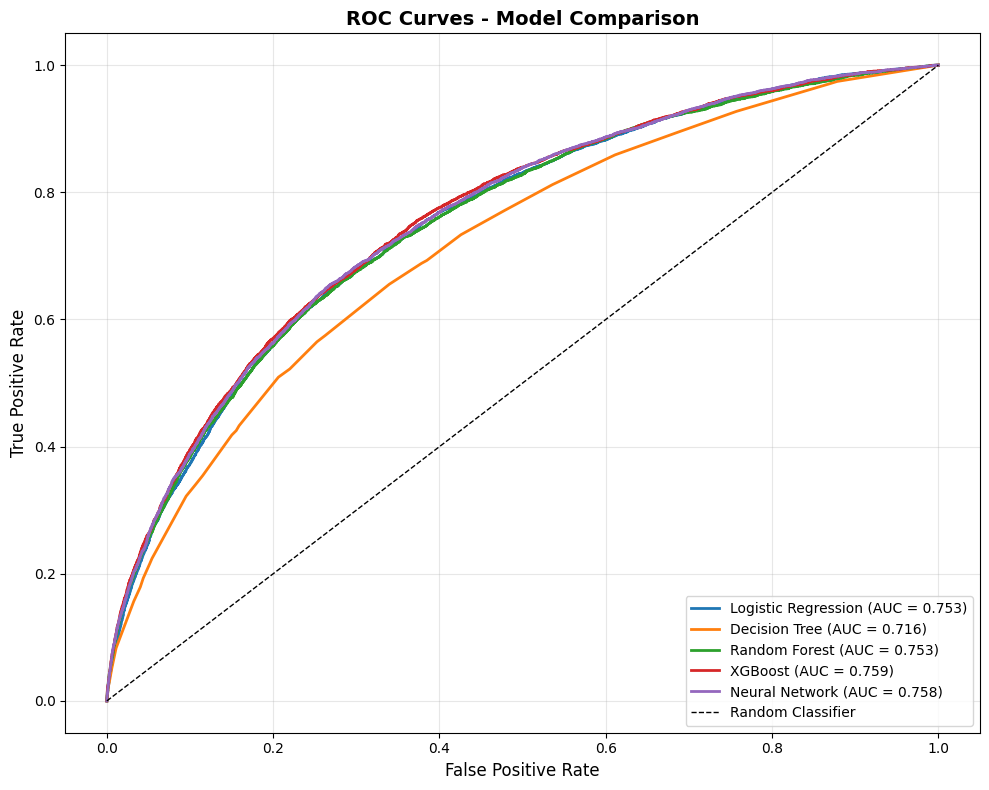

✓ ROC curves saved to 'roc_curves.png'


In [16]:
plt.figure(figsize=(10, 8))

# Plot ROC curve for each model
models_data = [
    ('Logistic Regression', lr_pred_proba, lr_roc_auc),
    ('Decision Tree', dt_pred_proba, dt_roc_auc),
    ('Random Forest', rf_pred_proba, rf_roc_auc),
    ('XGBoost', xgb_pred_proba, xgb_roc_auc),
    ('Neural Network', nn_pred_proba, nn_roc_auc)
]

for name, pred_proba, auc_score in models_data:
    fpr, tpr, _ = roc_curve(y_test, pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC curves saved to 'roc_curves.png'")

### 7.2 Confusion Matrices

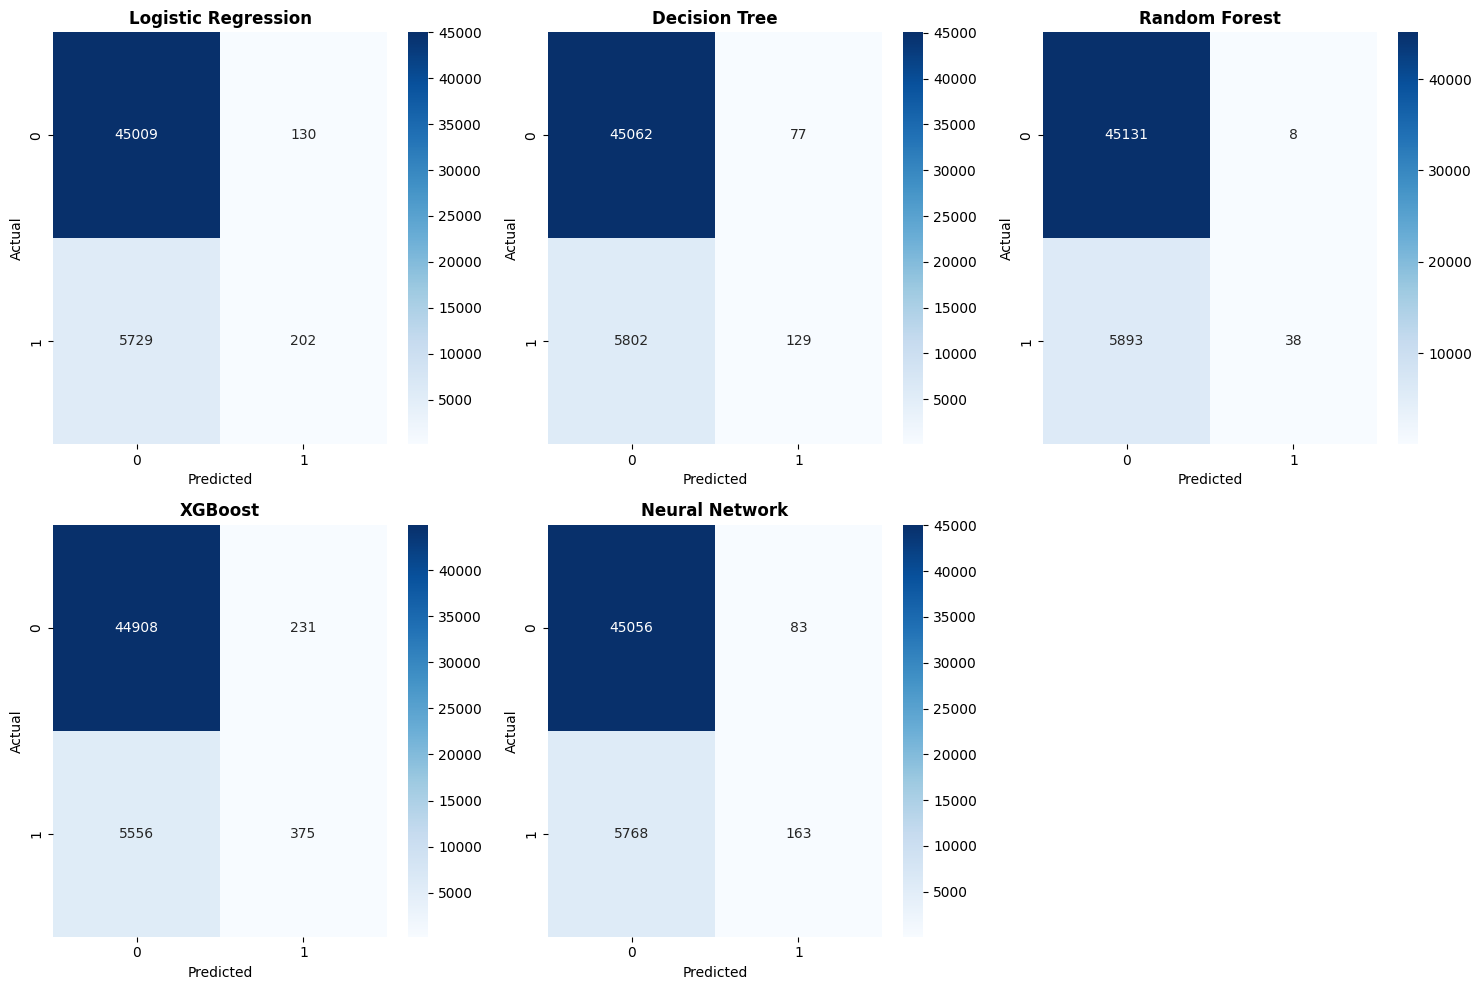

✓ Confusion matrices saved to 'confusion_matrices.png'


In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

predictions = [
    ('Logistic Regression', lr_pred),
    ('Decision Tree', dt_pred),
    ('Random Forest', rf_pred),
    ('XGBoost', xgb_pred),
    ('Neural Network', nn_pred)
]

for idx, (name, pred) in enumerate(predictions):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(name, fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices saved to 'confusion_matrices.png'")

### 7.3 Interpretability vs Performance Tradeoff

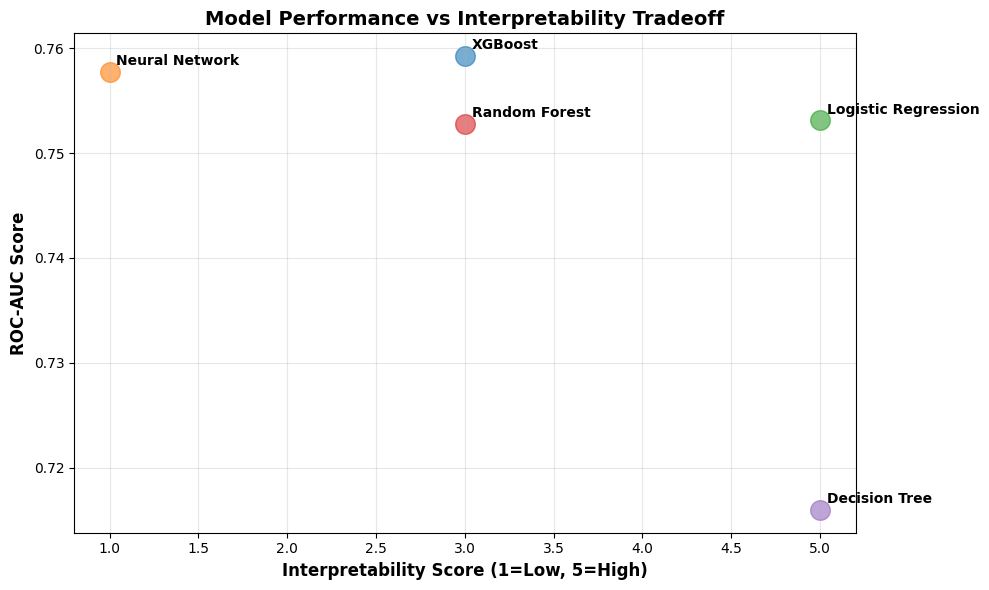

✓ Tradeoff plot saved to 'interpretability_performance_tradeoff.png'

INTERPRETABILITY-PERFORMANCE ANALYSIS
Best overall performance (ROC-AUC): 0.7593
Best interpretable model (ROC-AUC): 0.7531
Performance gap: 0.0061 (0.81%)


In [18]:
# Assign interpretability scores (1-5 scale)
interpretability_scores = {
    'Logistic Regression': 5,
    'Decision Tree': 5,
    'Random Forest': 3,
    'XGBoost': 3,
    'Neural Network': 1
}

results_df['Interpretability'] = results_df['Model'].map(interpretability_scores)

# Plot
plt.figure(figsize=(10, 6))

for idx, row in results_df.iterrows():
    plt.scatter(row['Interpretability'], row['ROC-AUC'], s=200, alpha=0.6)
    plt.annotate(row['Model'], 
                (row['Interpretability'], row['ROC-AUC']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold')

plt.xlabel('Interpretability Score (1=Low, 5=High)', fontsize=12, fontweight='bold')
plt.ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
plt.title('Model Performance vs Interpretability Tradeoff', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('interpretability_performance_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Tradeoff plot saved to 'interpretability_performance_tradeoff.png'")

# Calculate performance gap
max_auc = results_df['ROC-AUC'].max()
interpretable_models = results_df[results_df['Interpretability'] >= 4]
max_interpretable_auc = interpretable_models['ROC-AUC'].max()
performance_gap = max_auc - max_interpretable_auc

print(f"\n{'='*50}")
print("INTERPRETABILITY-PERFORMANCE ANALYSIS")
print(f"{'='*50}")
print(f"Best overall performance (ROC-AUC): {max_auc:.4f}")
print(f"Best interpretable model (ROC-AUC): {max_interpretable_auc:.4f}")
print(f"Performance gap: {performance_gap:.4f} ({performance_gap/max_auc*100:.2f}%)")
print(f"{'='*50}")

---
## Step 8: SHAP Analysis

Now let's perform SHAP analysis for each model to understand feature importance.

### 8.1 SHAP - Logistic Regression

Calculating SHAP values for Logistic Regression...


TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

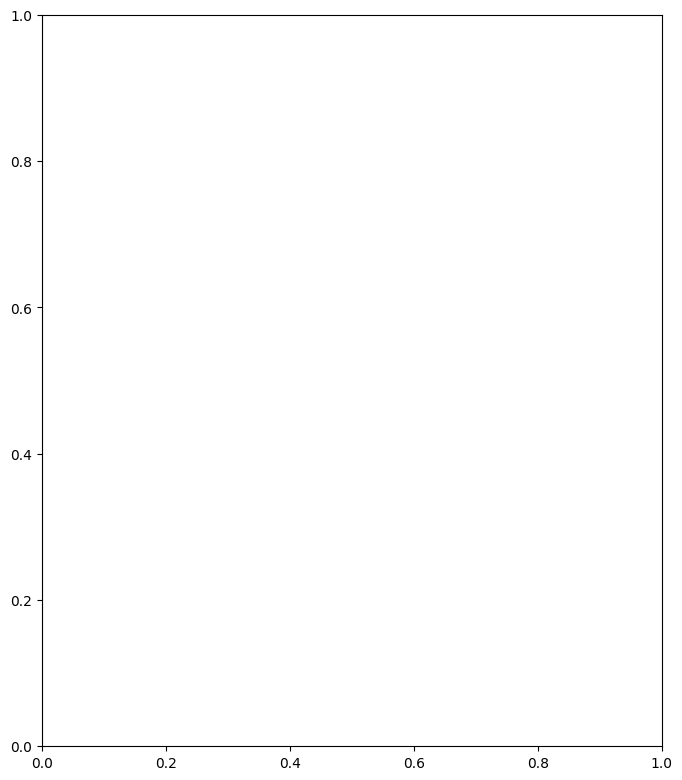

In [19]:
print("Calculating SHAP values for Logistic Regression...")

explainer_lr = shap.LinearExplainer(lr_model, X_test_scaled)
shap_values_lr = explainer_lr.shap_values(X_test_scaled)

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_lr, X_test_scaled, feature_names=X_test_scaled.columns, show=False)
plt.tight_layout()
plt.savefig('shap_logistic_regression.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP plot saved to 'shap_logistic_regression.png'")

### 8.2 SHAP - Decision Tree

In [ ]:
print("Calculating SHAP values for Decision Tree...")

explainer_dt = shap.TreeExplainer(dt_model)
shap_values_dt = explainer_dt.shap_values(X_test_scaled)

# For binary classification, take positive class
if isinstance(shap_values_dt, list):
    shap_values_dt = shap_values_dt[1]

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_dt, X_test_scaled, feature_names=X_test_scaled.columns, show=False)
plt.tight_layout()
plt.savefig('shap_decision_tree.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP plot saved to 'shap_decision_tree.png'")

### 8.3 SHAP - Random Forest

In [ ]:
print("Calculating SHAP values for Random Forest...")

explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test_scaled)

# For binary classification, take positive class
if isinstance(shap_values_rf, list):
    shap_values_rf = shap_values_rf[1]

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_rf, X_test_scaled, feature_names=X_test_scaled.columns, show=False)
plt.tight_layout()
plt.savefig('shap_random_forest.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP plot saved to 'shap_random_forest.png'")

### 8.4 SHAP - XGBoost

In [ ]:
print("Calculating SHAP values for XGBoost...")

explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test_scaled)

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_xgb, X_test_scaled, feature_names=X_test_scaled.columns, show=False)
plt.tight_layout()
plt.savefig('shap_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP plot saved to 'shap_xgboost.png'")

### 8.5 SHAP - Neural Network (using sampling for efficiency)

In [ ]:
print("Calculating SHAP values for Neural Network...")
print("(This may take a few minutes - using KernelExplainer on sampled data)\n")

# Sample background data for efficiency
background = shap.sample(X_test_scaled, 100)

# Create explainer
explainer_nn = shap.KernelExplainer(lambda x: nn_model.predict(x).flatten(), background)

# Calculate SHAP values on subset
shap_values_nn = explainer_nn.shap_values(X_test_scaled[:100])

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_nn, X_test_scaled[:100], feature_names=X_test_scaled.columns, show=False)
plt.tight_layout()
plt.savefig('shap_neural_network.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP plot saved to 'shap_neural_network.png'")

---
## Step 9: Summary and Key Findings

Let's summarize the key findings for your paper.

In [ ]:
print("\n" + "="*70)
print("ANALYSIS COMPLETE - KEY FINDINGS")
print("="*70)

# Best model
best_model = results_df.iloc[0]
print(f"\n1. BEST PERFORMING MODEL:")
print(f"   Model: {best_model['Model']}")
print(f"   ROC-AUC: {best_model['ROC-AUC']:.4f}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   F1-Score: {best_model['F1-Score']:.4f}")

# Interpretability-Performance tradeoff
print(f"\n2. INTERPRETABILITY-PERFORMANCE TRADEOFF:")
print(f"   Best overall: {max_auc:.4f}")
print(f"   Best interpretable: {max_interpretable_auc:.4f}")
print(f"   Gap: {performance_gap:.4f} ({performance_gap/max_auc*100:.2f}%)")
print(f"   → This is your KEY FINDING for the paper!")

# Model ranking
print(f"\n3. MODEL RANKING (by ROC-AUC):")
for idx, row in results_df.iterrows():
    print(f"   {idx+1}. {row['Model']}: {row['ROC-AUC']:.4f}")

print(f"\n4. FILES GENERATED FOR YOUR PAPER:")
print("   ✓ model_comparison_results.csv")
print("   ✓ roc_curves.png")
print("   ✓ confusion_matrices.png")
print("   ✓ shap_logistic_regression.png")
print("   ✓ shap_decision_tree.png")
print("   ✓ shap_random_forest.png")
print("   ✓ shap_xgboost.png")
print("   ✓ shap_neural_network.png")
print("   ✓ interpretability_performance_tradeoff.png")

print(f"\n5. NEXT STEPS:")
print("   → Open your LaTeX paper in TeXstudio")
print("   → Fill in Table 2 with the values from model_comparison_results.csv")
print("   → Fill in Table 3 with the interpretability tradeoff values above")
print("   → Copy all PNG files to your paper folder")
print("   → Start writing your Results and Discussion sections!")

print("\n" + "="*70)
print("READY TO WRITE YOUR PAPER! 🚀")
print("="*70)

---
## 📊 Analysis Complete!

All models have been trained, evaluated, and analyzed. You now have:

1. **Performance metrics** for all 5 models
2. **Visualizations** (ROC curves, confusion matrices, SHAP plots)
3. **Key findings** about the interpretability-performance tradeoff
4. **SHAP analysis** showing feature importance

### 🎯 Use These Results in Your Paper:

- **Table 2 (Model Performance)**: Use values from `model_comparison_results.csv`
- **Table 3 (Tradeoff)**: Use the performance gap calculated above
- **Figures**: Include all the PNG files in your LaTeX paper
- **Discussion**: Interpret why certain models performed better

### 📝 Next Steps:

1. Copy all PNG files to your LaTeX paper folder
2. Open `paper_template.tex` in TeXstudio
3. Fill in the results tables with your actual numbers
4. Write the Results and Discussion sections
5. Compile (F5) and see your complete paper!

**Good luck with your paper! 🎓**